In [14]:
import numpy as np
import numpy.linalg as la
from scipy.sparse import diags
import matplotlib.pyplot as plt

def get_xs(base):
    inFile = base + 'DIFFCOEF.txt'
    with open(inFile, 'r') as i:
        data = i.readlines()
    lines = list()
    for line in data:
        lines.append(line.split())
    D = float(lines[0][1]), float(lines[0][2])

    inFile = base + 'REMXS.txt'
    with open(inFile, 'r') as i:
        data = i.readlines()
    lines = list()
    for line in data:
        lines.append(line.split())
    sr = float(lines[0][1]), float(lines[0][2])

    inFile = base + 'SP0.txt'
    with open(inFile, 'r') as i:
        data = i.readlines()
    lines = list()
    for line in data:
        lines.append(line.split())
    # sigmaS21, sigmaS12
    ss = float(lines[0][3]), float(lines[0][2])

    inFile = base + 'CHIT.txt'
    with open(inFile, 'r') as i:
        data = i.readlines()
    lines = list()
    for line in data:
        lines.append(line.split())
    chi = float(lines[0][1]), float(lines[0][2])

    inFile = base + 'NSF.txt'
    with open(inFile, 'r') as i:
        data = i.readlines()
    lines = list()
    for line in data:
        lines.append(line.split())
    nusf = float(lines[0][1]), float(lines[0][2])
    
    return D, sr, ss, chi, nusf

# 2 Groups, 1 Region

In [2]:
base = '../xs/8/xs800000-500-100/htgr_2g_'
cD, csr, css, cchi, cnusf = get_xs(base + 'homoge_')

i =  356
k =  1.4152965641775215
0.17645760636291344


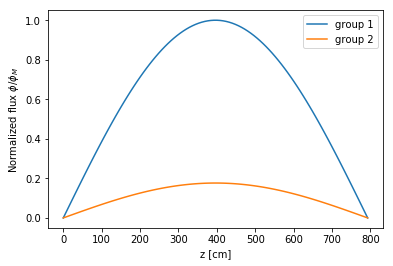

In [12]:
# Build system
N = 100
x = np.linspace(0, 793, num=N)
hx = x[1]-x[0]
hx2 = hx**2

# Diffusion matrix
DM1 = diags([1, -2, 1], [-1, 0, 1], shape=(N, N)).toarray()
DM2 = diags([1, -2, 1], [-1, 0, 1], shape=(N, N)).toarray()
D = np.zeros((2*N,2*N))
D[:N,:N] = cD[0]/hx2 * DM1
D[N:2*N,N:2*N] = cD[1]/hx2 * DM2

# Removal
SR = np.eye(2*N)
SR[:N,:N] = -csr[0] * SR[:N,:N]
SR[N:2*N,N:2*N] = -csr[1] * SR[N:2*N,N:2*N]

# In-scattering
aux1 = np.eye(N)
SS = np.zeros((2*N,2*N))
# No up-scattering for the moment
SS[:N,N:2*N] = css[0] * aux1
SS[N:2*N,:N] = css[1] * aux1

# Fission
F = np.zeros((2*N,2*N))
F[:N,:N] = cnusf[0] * aux1
F[:N,N:2*N] =  cnusf[1] * aux1

# Apply BCs
LHS = D + SR + SS
LHS[0] = np.zeros(2*N)
LHS[0, 0] = 1.0
LHS[N-1] = np.zeros(2*N)
LHS[N-1, N-1] = 1.0
LHS[N] = np.zeros(2*N)
LHS[N, N] = 1.0
LHS[2*N-1] = np.zeros(2*N)
LHS[2*N-1, 2*N-1] = 1.0

F[0] = np.zeros(2*N)
F[N-1] = np.zeros(2*N)
F[N] = np.zeros(2*N)
F[2*N-1] = np.zeros(2*N)

k = 1.0
flux_old = np.ones(2*N)
RHS = -F @ flux_old

def converged(k_old, k):
    if abs((k - k_old)/k_old) <= 1e-12:
        return True
    else:
        return False

for i in range(1000):
    k_old = k
    flux_new = np.linalg.solve(LHS, RHS)
    kp = sum((F @ flux_new)[:N])/sum((F @ flux_old)[:N])
    k = k_old * kp
    RHS = -(1/k) * F @ flux_new
    flux_old = flux_new
    if converged(k_old, k) == True:
        break

print('i = ', i)
print('k = ', k)
        
flux1 = flux_old[:N]
M = max(flux1)
flux1 /= M
flux2 = flux_old[N:2*N]
flux2 /= M

print(max(flux2)/max(flux1))

plt.plot(x, flux1, label='group 1')
plt.plot(x, flux2, label='group 2')
plt.legend(loc='upper right')
plt.ylabel(r"Normalized flux $\phi/\phi_M$")
plt.xlabel("z [cm]")
# plt.savefig("1D-fuel-eig-FDM", dpi=300, bbox_inches="tight")
plt.show()

# 2 Groups, 3 Regions

In [15]:
base = '../xs/8/xs800000-500-100/htgr_2g_'
cD, csr, css, cchi, cnusf = get_xs(base + 'homoge_')
bD, bsr, bss, bchi, bnusf = get_xs(base + 'brefl_')
tD, tsr, tss, tchi, tnusf = get_xs(base + 'trefl_')

i =  481
k =  1.4202101577495247


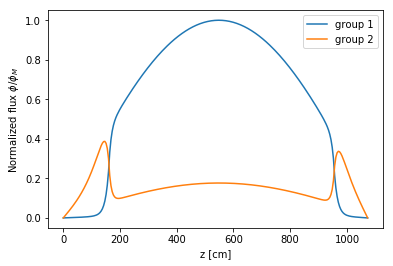

In [18]:
# Build system
N = 250
x = np.linspace(0, 160+793+120, num=N)
# print(x)

i = 0
while x[i] < 160:
    i += 1
Nb = i
while x[i] < 160+793:
    i += 1
Nc = i - Nb
Nt = N - Nc - Nb

# print(Nb)
# print(Nc)
# print(Nt)

h = x[1]-x[0]
h2 = h**2

# Diffusion matrix
DM = 1./h2*diags([1, -2, 1], [-1, 0, 1], shape=(N, N)).toarray()
D = np.zeros((2*N, 2*N))

D[:N, :N] = DM
D[N:2*N, N:2*N] = DM

D[:Nb] *= bD[0]
D[Nb:Nb+Nc] *= cD[0]
D[Nb+Nc:Nb+Nc+Nt] *= tD[0]

D[N:N+Nb] *= bD[1]
D[N+Nb:N+Nb+Nc] *= cD[1]
D[N+Nb+Nc:N+Nb+Nc+Nt] *= tD[1]

# Removal
SR = np.eye(2*N)
SR[:Nb, :Nb] *= -bsr[0]
SR[Nb:Nb+Nc, Nb:Nb+Nc] *= -csr[0]
SR[Nb+Nc:Nb+Nc+Nt, Nb+Nc:Nb+Nc+Nt] *= -tsr[0]
SR[N:N+Nb, N:N+Nb] *= -bsr[1]
SR[N+Nb:N+Nb+Nc, N+Nb:N+Nb+Nc] *= -csr[1]
SR[N+Nb+Nc:N+Nb+Nc+Nt, N+Nb+Nc:N+Nb+Nc+Nt] *= -tsr[1]

# In-scattering
aux1 = np.eye(N)
SS = np.zeros((2*N, 2*N))
SS[:Nb, N:N+Nb] = bss[0] * aux1[:Nb, :Nb]
SS[Nb:Nb+Nc, N+Nb:N+Nb+Nc] = css[0] * aux1[Nb:Nb+Nc, Nb:Nb+Nc]
SS[Nb+Nc:Nb+Nc+Nt, N+Nb+Nc:N+Nb+Nc+Nt] = tss[0] * aux1[Nb+Nc:Nb+Nc+Nt, Nb+Nc:Nb+Nc+Nt]
SS[N:N+Nb, :Nb] = bss[1] * aux1[:Nb, :Nb]
SS[N+Nb:N+Nb+Nc, Nb:Nb+Nc] = css[1] * aux1[Nb:Nb+Nc, Nb:Nb+Nc]
SS[N+Nb+Nc:N+Nb+Nc+Nt, Nb+Nc:Nb+Nc+Nt] = tss[1] * aux1[Nb+Nc:Nb+Nc+Nt, Nb+Nc:Nb+Nc+Nt]

# Fission
F = np.zeros((2*N, 2*N))
F[Nb:Nb+Nc, Nb:Nb+Nc] = cnusf[0] * aux1[Nb:Nb+Nc, Nb:Nb+Nc]
F[Nb:Nb+Nc, N+Nb:N+Nb+Nc] = cnusf[1] * aux1[Nb:Nb+Nc, Nb:Nb+Nc]

# Apply BCs
LHS = D + SR + SS
LHS[0] = np.zeros(2*N)
LHS[0, 0] = 1.0
LHS[N-1] = np.zeros(2*N)
LHS[N-1, N-1] = 1.0
LHS[N] = np.zeros(2*N)
LHS[N, N] = 1.0
LHS[2*N-1] = np.zeros(2*N)
LHS[2*N-1, 2*N-1] = 1.0

F[0] = np.zeros(2*N)
F[N-1] = np.zeros(2*N)
F[N] = np.zeros(2*N)
F[2*N-1] = np.zeros(2*N)

k = 1.0
flux_old = np.ones(2*N)
RHS = -F @ flux_old

def converged(k_old, k):
    if abs((k - k_old)/k_old) <= 1e-10:
        return True
    else:
        return False

for i in range(1000):
    k_old = k
    flux_new = np.linalg.solve(LHS, RHS)
    #k = k_old * sum(F @ flux_new)/sum(F @ flux_old)
    kp = sum(F @ flux_new)/sum(F @ flux_old)
    #kp = sum((F @ flux_new)[:N])/sum((F @ flux_old)[:N])
    k = k_old * kp
    #print(k)
    RHS = -(1./k) * F @ flux_new
    flux_old = flux_new
    if converged(k_old, k) == True:
        break

print('i = ', i)
print('k = ', k)
#flux = flux_old/(sum(flux_old)*hx)
flux = flux_old
flux1 = flux[:N]
flux2 = flux[N:2*N]

flux1 = flux_old[:N]
M = max(flux1)
flux1 /= M
flux2 = flux_old[N:2*N]
flux2 /= M

plt.plot(x, flux1, label='group 1')
plt.plot(x, flux2, label='group 2')
plt.legend(loc='upper right')
plt.ylabel(r"Normalized flux $\phi/\phi_M$")
plt.xlabel("z [cm]")
plt.savefig("1D-fuel-reflec-eig-FDM", dpi=300, bbox_inches="tight")
plt.show()